In [1]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../../')
from test_unet_helpers import *
from unet_models import unet11_MS

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expe

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

from glob import glob
class DG_GT_Dataset(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_bgrn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()

        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.img_files)

# Now that data is ready, set up the model and run through it

## some code for saving the model

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

## some code for setting up the model and performance eval

In [4]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# DO the same for pansharpened data

In [5]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn2')
ps_test_ds = DG_GT_Dataset(test_folder, channels='bgrn2')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgrn2')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
# smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
#model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.0001
bsize = 24 # was 32

#ps_model = UNet(in_channels=4, n_classes=1, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
ps_model = unet11_MS(num_bands=4, pretrained=False)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)

###### specify DataLoaders
n_workers=4 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
ps_train_dl = DataLoader(ps_train_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
# device=torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)

num_bands is  4
Let's use 4 GPUs!


In [7]:
device

device(type='cuda')

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
ps_step=0
# record time for one epoch
ps_rocs = []

#####################################################

t0 = time.time()
num_epochs = 100
for epoch in range(num_epochs):
    
#     try:
    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    for i, (inputs_, targets_) in enumerate(ps_train_dl):

        #print('hi')

        # get the inputs
        targets_ = targets_.type(torch.FloatTensor)

        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = ps_model(inputs)

        # zero parameter gradients
        ps_optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = ps_criterion(outputs, targets)                
        i_loss.backward()
        ps_optimizer.step()
        ps_step+=1

        running_loss += i_loss
        
        if i%5 == 0: # print/store every 10
            ps_losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        ps_rocs.append(tu[1])


    ps_losses_ep.append(running_loss)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

    # early exit critera
    if len(ps_rocs)>2:
        if (np.abs(ps_rocs[-1] - ps_rocs[-2]) < 0.009) and (ps_rocs[-1] > 0.98):
            print('area under curve not changing significantly, exit loop')
            break_flag = False
            
            if break_flag:
                break

#     except Exception as e:
#         print('something happened')
#         print(e)
#         break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  24
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 34.41802930831909 seconds
on epoch 2
epoch: 2, LOSS=1.2469323873519897, ROC_AUC=0.6536804796641161 
time for epoch 2: 3.15224027633667 seconds
on epoch 3
time for epoch 3: 2.492034673690796 seconds
on epoch 4
epoch: 4, LOSS=1.2369130849838257, ROC_AUC=0.759328516991146 
time for epoch 4: 3.093251943588257 seconds
on epoch 5
time for epoch 5: 2.627641439437866 seconds
on epoch 6
epoch: 6, LOSS=1.0984174013137817, ROC_AUC=0.7880219220438195 
time for epoch 6: 3.1263880729675293 seconds
on epoch 7
time for epoch 7: 2.5070393085479736 seconds
on epoch 8
epoch: 8, LOSS=1.0641803741455078, ROC_AUC=0.8084891503833063 
time for epoch 8: 3.1344711780548096 seconds
on epoch 9
time for epoch 9: 2.501004457473755 seconds
on epoch 10
epoch: 10, LOSS=0.770168125629425, ROC_AUC=0.8511111023967453 
time for epoch 10: 3.121809959411621 seconds
on epoch 11
time for epoch 11: 2.571720600128174 seconds
on epoch 12
epoch: 12, LOSS=0.8949338793754578, ROC_AUC=0.8701341723039818 
time for e

time for epoch 93: 2.6437032222747803 seconds
on epoch 94
epoch: 94, LOSS=0.3600939214229584, ROC_AUC=0.9773503252352189 
time for epoch 94: 3.2086403369903564 seconds
on epoch 95
time for epoch 95: 2.575120687484741 seconds
on epoch 96
epoch: 96, LOSS=0.36777573823928833, ROC_AUC=0.9741547407264965 
time for epoch 96: 3.1901803016662598 seconds
on epoch 97
time for epoch 97: 2.6665191650390625 seconds
on epoch 98
epoch: 98, LOSS=0.41477084159851074, ROC_AUC=0.9693582932127827 
time for epoch 98: 3.236862897872925 seconds
on epoch 99
time for epoch 99: 2.576408624649048 seconds
on epoch 100
epoch: 100, LOSS=0.3451248109340668, ROC_AUC=0.9768870294321945 
time for epoch 100: 3.1790313720703125 seconds
total time:  318.3858857154846


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


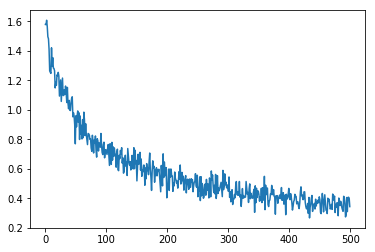

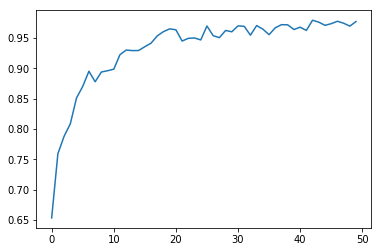

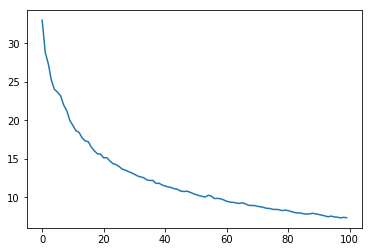

In [9]:
plt.plot(ps_losses)
plt.show()

plt.plot(ps_rocs)
plt.show()

plt.plot(ps_losses_ep)
plt.show()


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


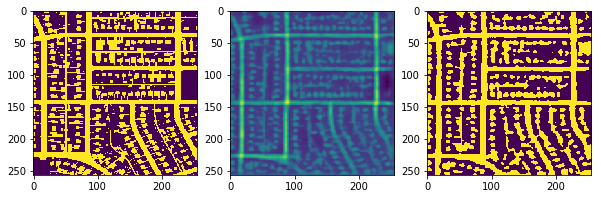

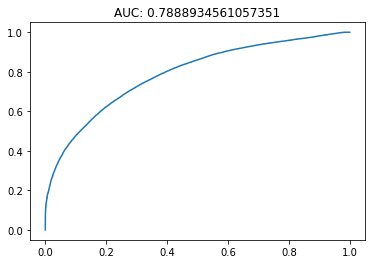

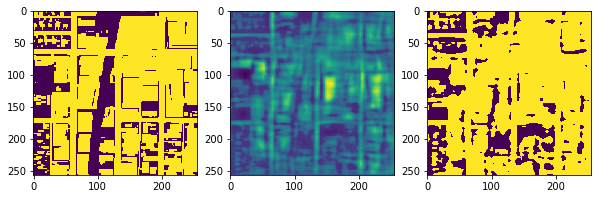

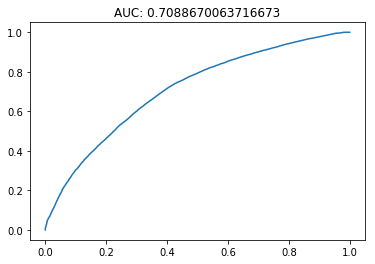

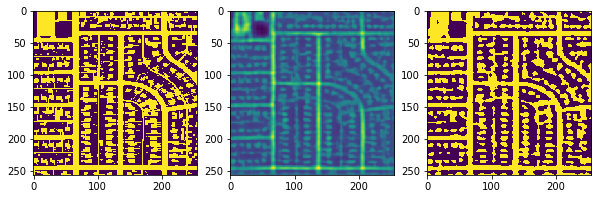

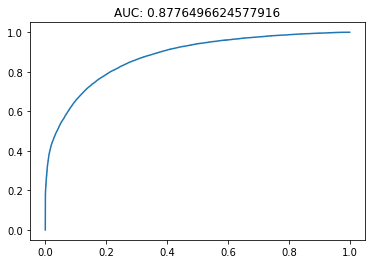

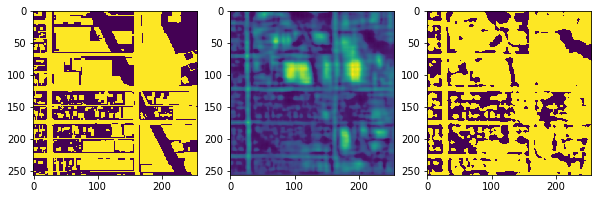

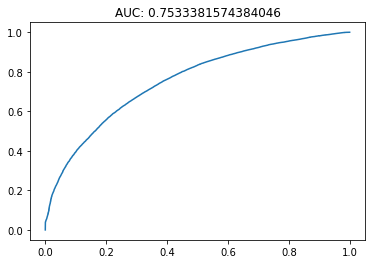

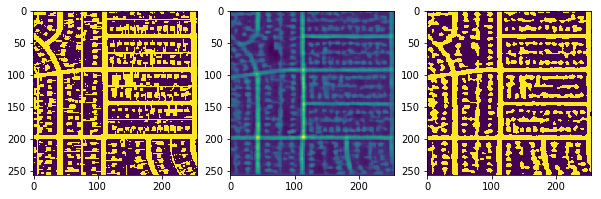

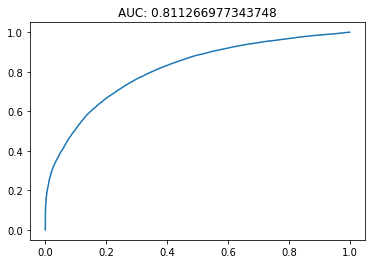

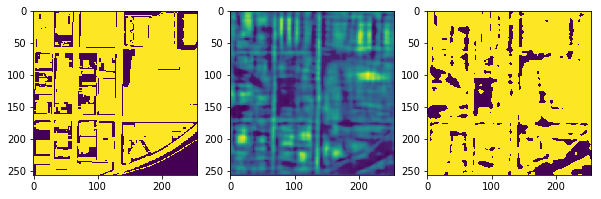

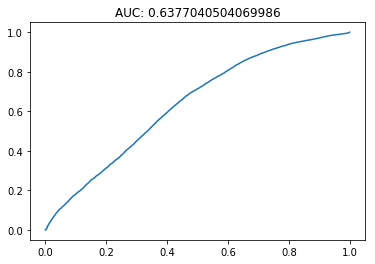

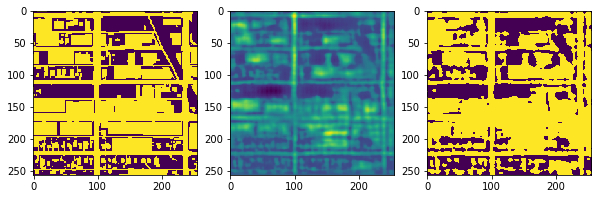

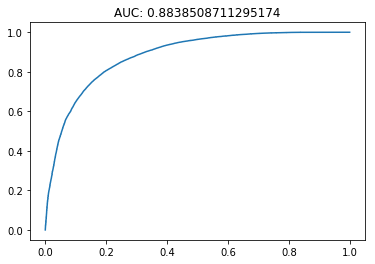

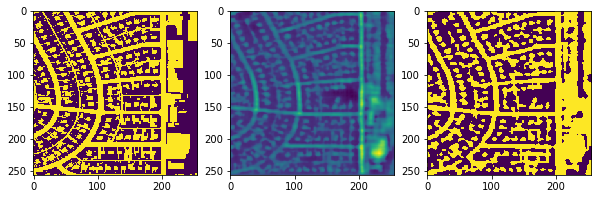

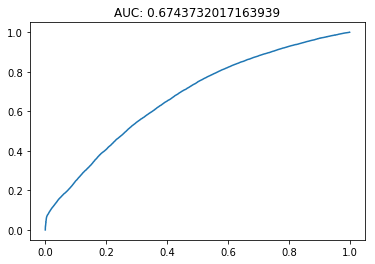

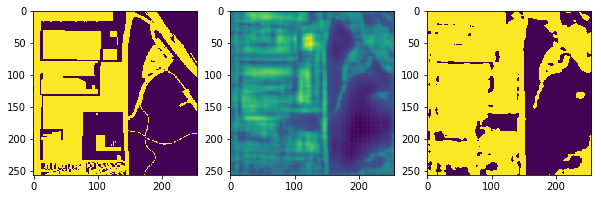

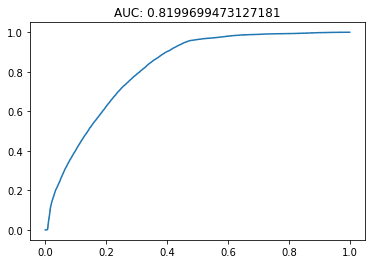

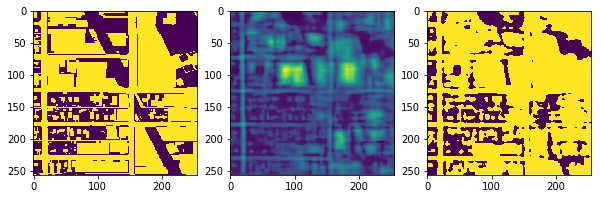

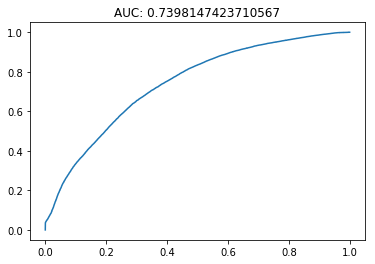

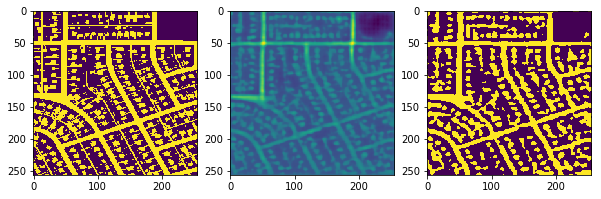

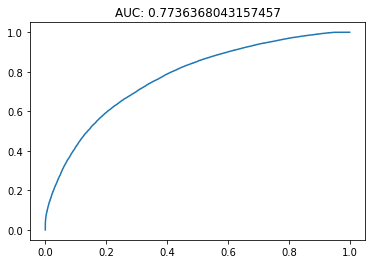

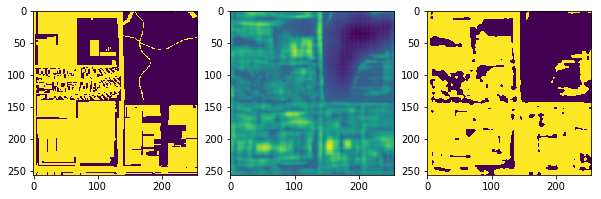

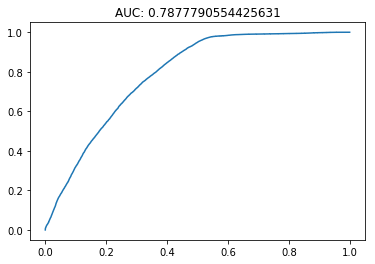

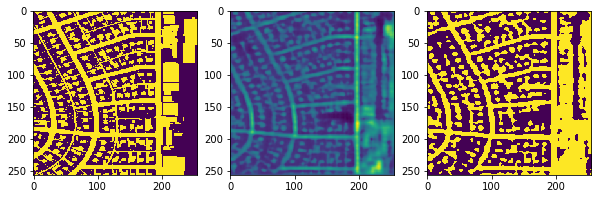

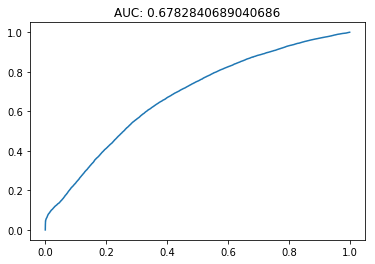

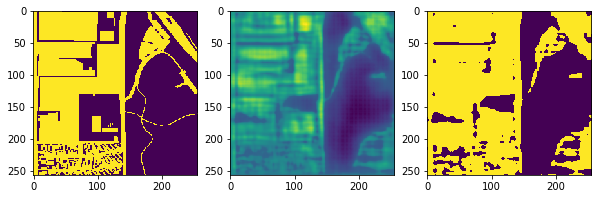

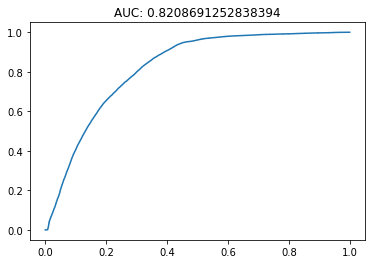

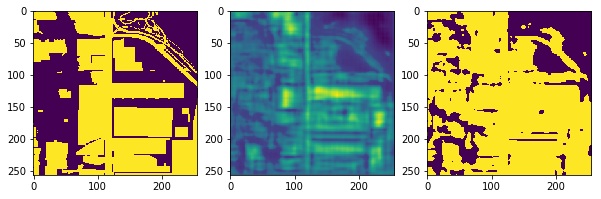

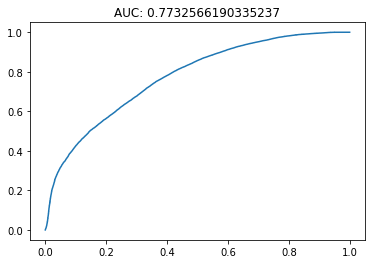

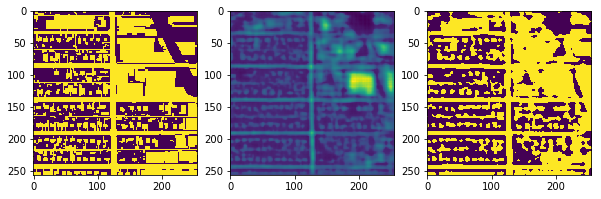

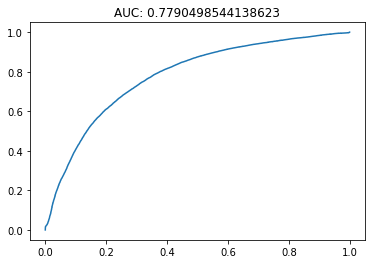

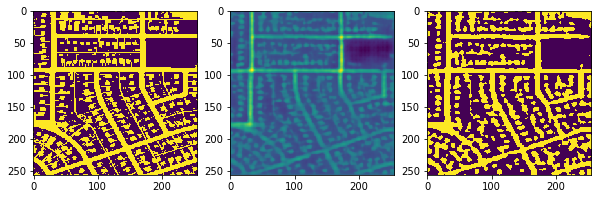

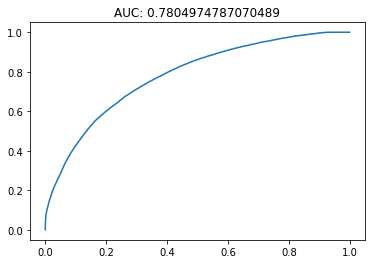

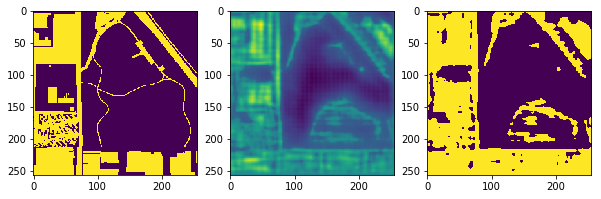

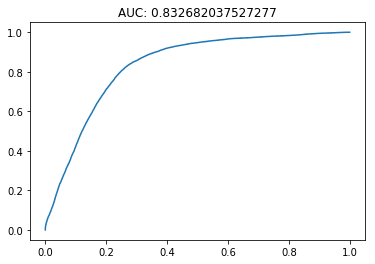

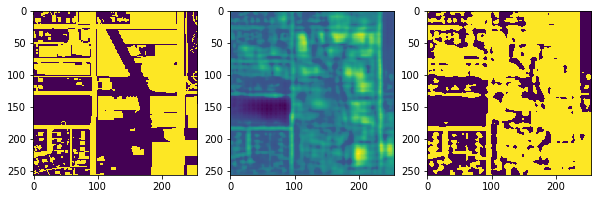

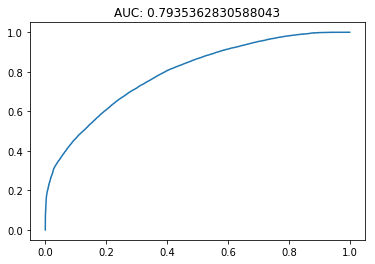

In [10]:
ps_model.eval()
for ind in range(1,20):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))


## save the model, AUC, and loss vectors

In [ ]:
save_res = False

if save_res:
    # directory
    save_dir = 'files_PS_bgrn1'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'bgrn1_ps_ep{}_step{}_b{}.pt'.format(num_epochs, step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': ep,
            'step': step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgrn1_ps_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgrn1_ps_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgrn1_ps_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(losses))